<a href="https://colab.research.google.com/github/adityavikramsingh07/Ml-knowledge/blob/main/LLM_Embeddings_vs_TF_IDF_vs_Bag_of_Words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files

uploaded = files.upload()

Saving BBC News Train.csv to BBC News Train.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Scikit-learn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    silhouette_score, adjusted_rand_score
)
from sklearn.preprocessing import LabelEncoder

# Our key import for building LLM embeddings: a Sentence Transformer model
from sentence_transformers import SentenceTransformer

# Plotting configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# ---------------------------------------------------------
# LOAD DATASET (LOCALLY)
# ---------------------------------------------------------
print("Loading BBC News dataset from local file...")

# Replaced the URL with your local file name
# Make sure 'BBC News Sample Solution.csv' matches the exact name of the file you uploaded
df = pd.read_csv('BBC News Train.csv')

print(f"Dataset loaded: {len(df)} documents")

# Check if 'category' column exists before printing stats to avoid errors
if 'category' in df.columns:
    print(f"Categories: {df['category'].unique()}")
    print(f"\nClass distribution:")
    print(df['category'].value_counts())
else:
    print("Warning: The column 'category' was not found in this CSV.")
    print("Available columns:", df.columns)

Loading BBC News dataset from local file...
Dataset loaded: 1490 documents
Available columns: Index(['ArticleId', 'Text', 'Category'], dtype='object')


In [7]:
print("\n" + "="*70)
print("DATA PREPARATION PRIOR TO GENERATING TEXT REPRESENTATIONS")
print("="*70)

# FIX: Use Capitalized column names 'Text' and 'Category'
texts = df['Text'].tolist()
labels = df['Category'].tolist()

# Encoding labels for classification
le = LabelEncoder()
y = le.fit_transform(labels)

# Splitting data (same split for all representation methods and ML models trained later)
X_text_train, X_text_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_text_train)} | Test set: {len(X_text_test)}")
print("Classes found:", le.classes_)


DATA PREPARATION PRIOR TO GENERATING TEXT REPRESENTATIONS

Train set: 1192 | Test set: 298
Classes found: ['business' 'entertainment' 'politics' 'sport' 'tech']


**Representation 1: Bag-of-Words (BoW)**

In [8]:
print("\n[1] Bag-of-Words...")
start = time()

# The CountVectorizer class is used to apply BoW
bow_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=2,
    stop_words='english'
)

X_bow_train = bow_vectorizer.fit_transform(X_text_train)
X_bow_test = bow_vectorizer.transform(X_text_test)

bow_time = time() - start

print(f"   Done in {bow_time:.2f}s")
print(f"   Shape: {X_bow_train.shape} (documents × vocabulary)")
print(f"   Sparsity: {(1 - X_bow_train.nnz / (X_bow_train.shape[0] * X_bow_train.shape[1])) * 100:.1f}%")
print(f"   Memory: {X_bow_train.data.nbytes / 1024:.1f} KB")


[1] Bag-of-Words...
   Done in 0.34s
   Shape: (1192, 5000) (documents × vocabulary)
   Sparsity: 97.7%
   Memory: 1078.8 KB


**Representation 2: TF-IDF**

In [9]:
print("\n[2] TF-IDF...")
start = time()

# Using TfidfVectorizer class to apply TF-IDF based on word frequencies
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    stop_words='english'
)

X_tfidf_train = tfidf_vectorizer.fit_transform(X_text_train)
X_tfidf_test = tfidf_vectorizer.transform(X_text_test)

tfidf_time = time() - start

print(f"   Done in {tfidf_time:.2f}s")
print(f"   Shape: {X_tfidf_train.shape}")
print(f"   Sparsity: {(1 - X_tfidf_train.nnz / (X_tfidf_train.shape[0] * X_tfidf_train.shape[1])) * 100:.1f}%")
print(f"   Memory: {X_tfidf_train.data.nbytes / 1024:.1f} KB")


[2] TF-IDF...
   Done in 0.34s
   Shape: (1192, 5000)
   Sparsity: 97.7%
   Memory: 1078.8 KB


**Representation 3: LLM Embeddings**

In [11]:
from time import time
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- FIX: Define X_text_train before using it ---
# (Assuming 'df' is loaded. If not, run df = pd.read_csv('BBC News Train.csv') first)
texts = df['Text'].tolist()
labels = df['Category'].tolist()
y = LabelEncoder().fit_transform(labels)

X_text_train, X_text_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)
# ------------------------------------------------

print("\n[3] LLM Embeddings...")
start = time()

# Loading a pre-trained sentence transformer model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

X_emb_train = embedding_model.encode(
    X_text_train,
    show_progress_bar=True,
    batch_size=32
)
X_emb_test = embedding_model.encode(
    X_text_test,
    show_progress_bar=False,
    batch_size=32
)

emb_time = time() - start

print(f"   Done in {emb_time:.2f}s")
print(f"   Shape: {X_emb_train.shape} (documents × embedding_dim)")
print(f"   Sparsity: 0.0% (dense representation)")
print(f"   Memory: {X_emb_train.nbytes / 1024:.1f} KB")


[3] LLM Embeddings...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

   Done in 7.93s
   Shape: (1192, 384) (documents × embedding_dim)
   Sparsity: 0.0% (dense representation)
   Memory: 1788.0 KB


**Comparison 1: Text Classification**

In [12]:
print("\n" + "="*70)
print("COMPARISON 1: SUPERVISED CLASSIFICATION")
print("="*70)

# Defining the three types of classifiers to train
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

# Storing results in a Python collection (list)
classification_results = []

# Evaluating each representation with each classifier
representations = {
    'BoW': (X_bow_train, X_bow_test),
    'TF-IDF': (X_tfidf_train, X_tfidf_test),
    'LLM Embeddings': (X_emb_train, X_emb_test)
}

for rep_name, (X_tr, X_te) in representations.items():
    print(f"\nTesting {rep_name}:")
    print("-" * 50)

    for clf_name, clf in classifiers.items():
        # Train
        start = time()
        clf.fit(X_tr, y_train)
        train_time = time() - start

        # Predict
        start = time()
        y_pred = clf.predict(X_te)
        pred_time = time() - start

        # Evaluate
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"   {clf_name:20s} | Acc: {acc:.3f} | F1: {f1:.3f} | Train: {train_time:.2f}s")

        classification_results.append({
            'Representation': rep_name,
            'Classifier': clf_name,
            'Accuracy': acc,
            'F1-Score': f1,
            'Train Time': train_time,
            'Predict Time': pred_time
        })

# Converting results to DataFrame for interpretability and easier comparison
results_df = pd.DataFrame(classification_results)


COMPARISON 1: SUPERVISED CLASSIFICATION

Testing BoW:
--------------------------------------------------
   Logistic Regression  | Acc: 0.960 | F1: 0.959 | Train: 0.86s
   Random Forest        | Acc: 0.943 | F1: 0.943 | Train: 1.97s
   SVM                  | Acc: 0.956 | F1: 0.956 | Train: 1.71s

Testing TF-IDF:
--------------------------------------------------
   Logistic Regression  | Acc: 0.963 | F1: 0.963 | Train: 1.17s
   Random Forest        | Acc: 0.953 | F1: 0.953 | Train: 1.74s
   SVM                  | Acc: 0.977 | F1: 0.976 | Train: 2.87s

Testing LLM Embeddings:
--------------------------------------------------
   Logistic Regression  | Acc: 0.973 | F1: 0.973 | Train: 0.10s
   Random Forest        | Acc: 0.950 | F1: 0.949 | Train: 1.92s
   SVM                  | Acc: 0.973 | F1: 0.973 | Train: 0.07s


**Input code for visualizing results:**

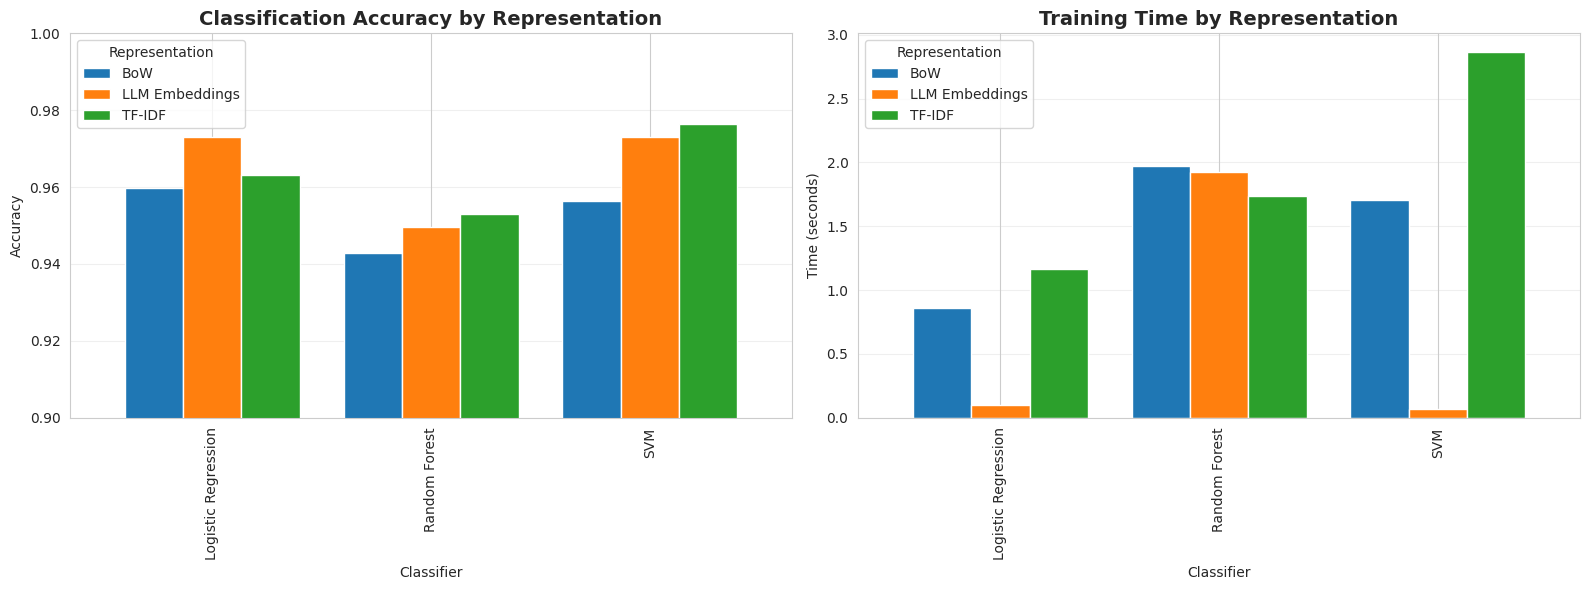


BEST PERFORMERS:
--------------------------------------------------
Best Accuracy: TF-IDF + SVM = 0.977
Fastest Training: LLM Embeddings + SVM = 0.07s


In [13]:
# Creating visualization plots for direct comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy comparison
pivot_acc = results_df.pivot(index='Classifier', columns='Representation', values='Accuracy')
pivot_acc.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Classification Accuracy by Representation', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Classifier')
axes[0].legend(title='Representation')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.9, 1.0])

# Plot 2: Training time comparison
pivot_time = results_df.pivot(index='Classifier', columns='Representation', values='Train Time')
pivot_time.plot(kind='bar', ax=axes[1], width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_title('Training Time by Representation', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_xlabel('Classifier')
axes[1].legend(title='Representation')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Identifying best performers
print("\nBEST PERFORMERS:")
print("-" * 50)
best_acc = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"Best Accuracy: {best_acc['Representation']} + {best_acc['Classifier']} = {best_acc['Accuracy']:.3f}")

fastest = results_df.loc[results_df['Train Time'].idxmin()]
print(f"Fastest Training: {fastest['Representation']} + {fastest['Classifier']} = {fastest['Train Time']:.2f}s")

**Comparison 2: Document Clustering**

In [14]:
print("\n" + "="*70)
print("COMPARISON 2: DOCUMENT CLUSTERING")
print("="*70)

# Using full dataset for clustering (no train/test split needed)
all_texts = texts
all_labels = y

# Generating representations once more
print("\nGenerating representations for full dataset...")

X_bow_full = bow_vectorizer.fit_transform(all_texts)
X_tfidf_full = tfidf_vectorizer.fit_transform(all_texts)
X_emb_full = embedding_model.encode(all_texts, show_progress_bar=True, batch_size=32)

# Clustering with K-Means (k=5, matching ground-truth categories)
n_clusters = len(np.unique(all_labels))
clustering_results = []

representations_full = {
    'BoW': X_bow_full,
    'TF-IDF': X_tfidf_full,
    'LLM Embeddings': X_emb_full
}

for rep_name, X_full in representations_full.items():
    print(f"\nClustering with {rep_name}:")

    start = time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_full)
    cluster_time = time() - start

    # Evaluate
    silhouette = silhouette_score(X_full, cluster_labels)
    ari = adjusted_rand_score(all_labels, cluster_labels)

    print(f"   Silhouette Score: {silhouette:.3f}")
    print(f"   Adjusted Rand Index: {ari:.3f}")
    print(f"   Time: {cluster_time:.2f}s")

    clustering_results.append({
        'Representation': rep_name,
        'Silhouette': silhouette,
        'ARI': ari,
        'Time': cluster_time
    })

clustering_df = pd.DataFrame(clustering_results)


COMPARISON 2: DOCUMENT CLUSTERING

Generating representations for full dataset...


Batches:   0%|          | 0/47 [00:00<?, ?it/s]


Clustering with BoW:
   Silhouette Score: 0.110
   Adjusted Rand Index: 0.154
   Time: 0.43s

Clustering with TF-IDF:
   Silhouette Score: 0.016
   Adjusted Rand Index: 0.569
   Time: 0.32s

Clustering with LLM Embeddings:
   Silhouette Score: 0.066
   Adjusted Rand Index: 0.905
   Time: 0.23s


**Code for visualizing results:**

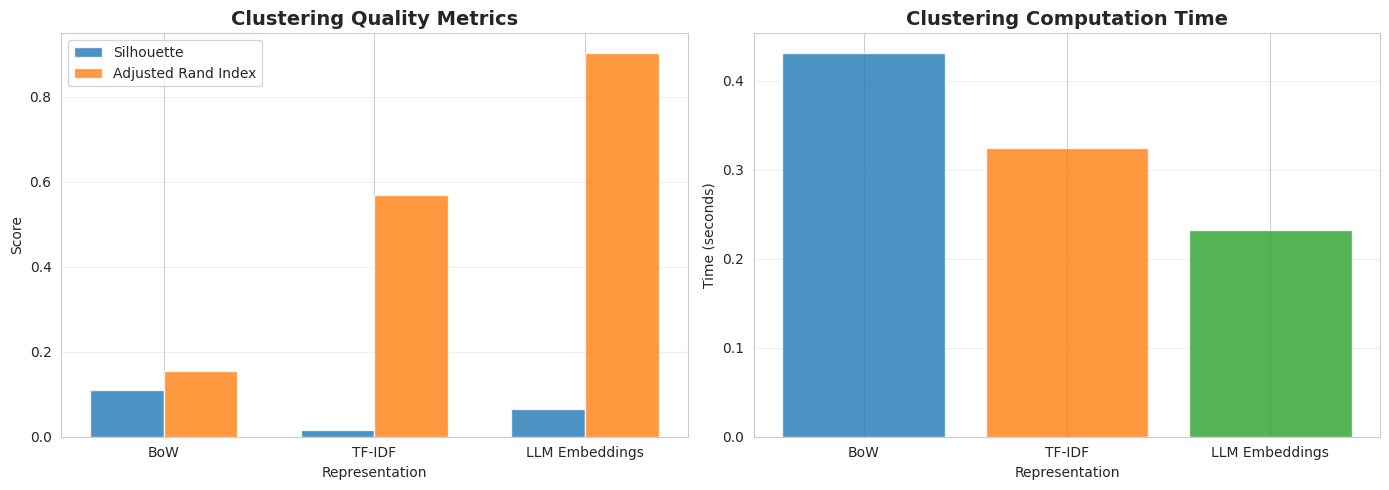


BEST CLUSTERING PERFORMER:
--------------------------------------------------
LLM Embeddings: ARI = 0.905, Silhouette = 0.066


In [15]:
# Creating comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Clustering quality metrics
x = np.arange(len(clustering_df))
width = 0.35

axes[0].bar(x - width/2, clustering_df['Silhouette'], width, label='Silhouette', alpha=0.8)
axes[0].bar(x + width/2, clustering_df['ARI'], width, label='Adjusted Rand Index', alpha=0.8)
axes[0].set_xlabel('Representation')
axes[0].set_ylabel('Score')
axes[0].set_title('Clustering Quality Metrics', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(clustering_df['Representation'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Clustering time
axes[1].bar(clustering_df['Representation'], clustering_df['Time'], color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
axes[1].set_xlabel('Representation')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Clustering Computation Time', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nBEST CLUSTERING PERFORMER:")
print("-" * 50)
best_cluster = clustering_df.loc[clustering_df['ARI'].idxmax()]
print(f"{best_cluster['Representation']}: ARI = {best_cluster['ARI']:.3f}, Silhouette = {best_cluster['Silhouette']:.3f}")